# Final Project: Car Damage Detection

## Preperation
We check for the system environment and install the required packages.

In [14]:
# Check if NVIDIA GPU is enabled and available
!nvidia-smi

Wed Mar  6 17:13:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8               1W / 100W |    837MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
# Check directory
!ls -l

total 488
drwxr-xr-x 3 abzy abzy   4096 Mar  6 15:48 annotations
-rw-rw-r-- 1 abzy abzy 238124 Mar  6 17:12 CarDamageDetection.ipynb
-rw-rw-r-- 1 abzy abzy 127712 Mar  6 17:11 model.png
drwxrwxr-x 2 abzy abzy   4096 Mar  6 17:12 modelREST
drwxr-xr-x 8 abzy abzy  12288 Mar  6 15:50 test
drwxr-xr-x 8 abzy abzy  73728 Mar  6 15:49 train
drwxr-xr-x 8 abzy abzy  28672 Mar  6 15:51 val


In [16]:
# Import TensorFlow and configure GPU memory growth
import tensorrt as trt
import tensorflow as tf
import tensorflow.keras as keras

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Dateset
Dateset: [https://drive.google.com/file/d/1bbyqVCKZX5Ur5Zg-uKj0jD0maWAVeOLx/view?usp=sharing](Link)

In [17]:
print("Number of train pictures:")
!ls train -1 -R | wc -l
print("Number of validation pictures:")
!ls val -1 -R | wc -l
print("Number of test pictures:")
!ls test -1 -R | wc -l

Number of train pictures:
2835


Number of validation pictures:
829
Number of test pictures:
393


In [18]:
image_size = (250, 167)
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    "train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int",
)

Found 2816 files belonging to 6 classes.


In [19]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    "val",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int"
)

Found 810 files belonging to 6 classes.


In [20]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
]

def augmentation(images):
    for layer in augmentation_layers:
        images = layer(images)
    return images

# Model

In [21]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile("adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 248, 165, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 124, 82, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 80, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 40, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 59, 38, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 29, 19, 128)      

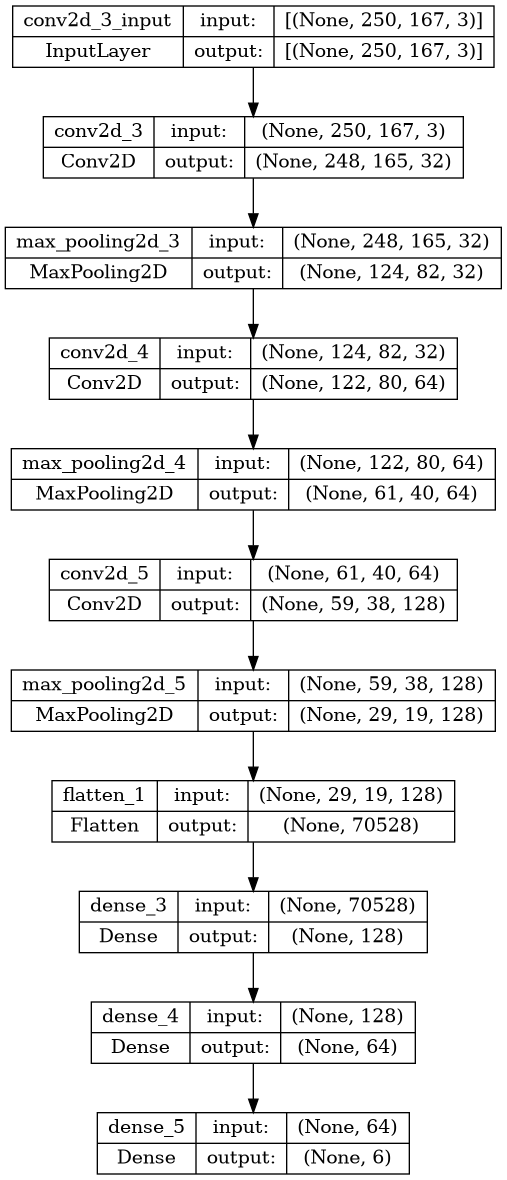

In [22]:
keras.utils.plot_model(model, show_shapes=True)

# Training

In [23]:
history = model.fit(train_ds, epochs=10, batch_size=16)

Epoch 1/10
176/176 [==============================] - 4s 19ms/step - loss: 14.4392 - accuracy: 0.4190
Epoch 2/10
176/176 [==============================] - 3s 18ms/step - loss: 1.1762 - accuracy: 0.5241
Epoch 3/10
176/176 [==============================] - 3s 19ms/step - loss: 0.8252 - accuracy: 0.6754
Epoch 4/10
176/176 [==============================] - 3s 18ms/step - loss: 0.5382 - accuracy: 0.7990
Epoch 5/10
176/176 [==============================] - 3s 19ms/step - loss: 0.4077 - accuracy: 0.8558
Epoch 6/10
176/176 [==============================] - 3s 19ms/step - loss: 0.3843 - accuracy: 0.8835
Epoch 7/10
176/176 [==============================] - 3s 19ms/step - loss: 0.2599 - accuracy: 0.9308
Epoch 8/10
176/176 [==============================] - 3s 18ms/step - loss: 0.2087 - accuracy: 0.9400
Epoch 9/10
176/176 [==============================] - 3s 19ms/step - loss: 0.1564 - accuracy: 0.9535
Epoch 10/10
176/176 [==============================] - 3s 19ms/step - loss: 0.1256 - accur

In [24]:
model.save("modelREST/model.h5")

/home/abzy/.venvs/pythonVenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

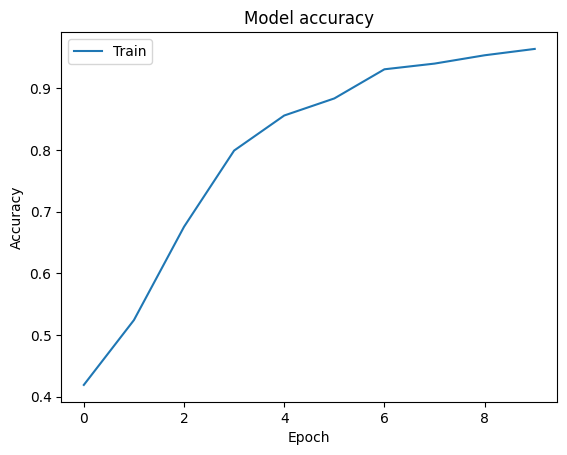

In [25]:
# draw plot based on history
import matplotlib.pyplot as plt

history = history.history

plt.plot(history["accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train"], loc="upper left")
plt.show()

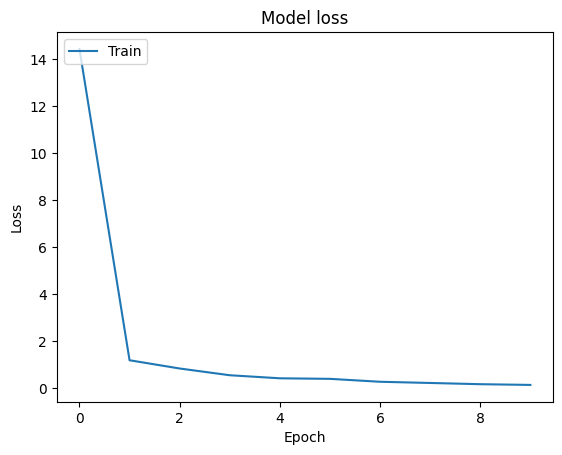

In [26]:
# loss graph
plt.plot(history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train"], loc="upper left")
plt.show()